Distribution of Listening events by artists (number of listeners for the artist)

In [ ]:
# Importing libarary and downloading the pre-processed user database
import pandas as pd
df = pd.read_csv('output_data_new.txt', delimiter='\t' )
df

,user_id,country,age,gender,playcount,registered_unixtime
0,384,UK,35,m,42139,1035849600
1,3653,UK,31,m,18504,1041033600
2,4813,US,43,m,640,1050364800
3,5069,AT,30,m,31867,1051488000
4,6958,US,36,m,34788,1057536000
...,...,...,...,...,...,...
47581,50759670,US,25,m,467,1342153673
47582,50796677,PL,110,f,1495,1342344762
47583,50864998,PT,-1,m,74,1342696833
47584,50871714,BY,19,f,569,1342728447


Extracting female user and artist data from the UAM and computing some basic statistics  

In [ ]:
# importing the required librariries for reading the matlab file and loading the UAM
import numpy as np
import h5py
from scipy import sparse

# Defining the file names
UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'
USER_DATA_FILE = 'output_data_new.txt'
STATISTICS_OUTPUT_FILE_FEM = 'LFM-1b_stats_users.txt'

# Defining a function to read the User-Artist Matrix (UAM) from a MATLAB file and process user data
def read_UAM(m_file, user_data_file):
    mf = h5py.File(m_file, 'r') # Opening the MATLAB file using h5py

    # Reading the user and artist indices from the MATLAB file and converting them to np.int64
    user_ids = np.array(mf['idx_users']).astype(np.int64)[:47586] # slicing notation to extract a subset
    artist_ids = np.array(mf['idx_artists']).astype(np.int64)

    # Loading the UAM
    # Converting the sparse UAM data from the MATLAB file into a CSR sparse matrix
    UAM = sparse.csr_matrix((mf['/LEs/']['data'][()],
                             mf['/LEs/']['ir'][()],
                             mf['/LEs/']['jc'][()])).transpose()

    # Reading gender and filtering only female information from the user data file
    # Loading the user data from the tab-separated file, skipping the header (first row)
    user_data = np.loadtxt(user_data_file, dtype=np.str_, delimiter='\t', skiprows=1)

    # Extracting the gender information and converting it to binary values (1 for female, 0 for male)
    gender_ids = (user_data[:, 3] == 'f').astype(np.int64)

    # Selecting only the female user IDs from the UAM and limiting the number to 47586
    # Filtering users based on gender (female)
    female_user_ids = user_ids[gender_ids == 1][:47586]

    # Finding the common users between the user data file and UAM
    common_users = np.intersect1d(user_ids, female_user_ids)

    # Get the indices of common users in the UAM
    user_indices = np.where(np.isin(user_ids, common_users))[0]
    artist_indices = np.where(np.isin(artist_ids, artist_ids))[0]
    UAM = UAM[user_indices][:, artist_indices]

    # Getting the user and artist indices to access UAM
    UAM_user_idx = UAM.indices
    UAM_artist_idx = UAM.indptr

    # Returning the processed UAM and additional data
    return UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids


if __name__ == '__main__':
    # Reading the UAM
    UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids = read_UAM(UAM_MATLAB_FILE, USER_DATA_FILE)
    print('Female Users: ', len(common_users))
    print('Artists: ', len(artist_ids))

    # Computing some basic statistics with respect to the number of listeners each artist has
    pc_sum = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_unique_artist = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_mean = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_median = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_std = np.zeros((len(artist_ids)), dtype=np.float32)

    for i in range(0, len(artist_ids)):  # Looping over all artists
        pc_i = UAM.getcol(i).toarray()  # To get the column corresponding to the artist
        idx_nz = np.nonzero(pc_i)
        pc_unique_artist[i] = len(idx_nz[0])  # Number of listeners for the artist
        pc_sum[i] = np.sum(pc_i[idx_nz])
        pc_mean[i] = np.mean(pc_i[idx_nz])
        pc_std[i] = np.std(pc_i[idx_nz])
        pc_median[i] = np.median(pc_i[idx_nz])
        print('Artist ' + str(i) + " Playcount: " + str(pc_sum[i]) +
              "   Listeners: " + str(pc_unique_artist[i]) +
              "   Mean PC/listener: " + str(pc_mean[i]) +
              "   Std. PC/listener: " + str(pc_std[i]) +
              "   Median PC/listener: " + str(pc_median[i]))

    # Storing the computed statistice to a file
    np.savetxt(STATISTICS_OUTPUT_FILE_FEM, np.column_stack((pc_sum, pc_unique_artist, pc_mean, pc_std, pc_median)), fmt="%.3f")


Female Users:  13501
Artists:  585095
Artist 0 Playcount: 218257   Listeners: 2414   Mean PC/listener: 90.41301   Std. PC/listener: 389.91113   Median PC/listener: 9.0
Artist 1 Playcount: 15971   Listeners: 989   Mean PC/listener: 16.148636   Std. PC/listener: 51.60977   Median PC/listener: 3.0
Artist 2 Playcount: 271973   Listeners: 5121   Mean PC/listener: 53.109352   Std. PC/listener: 177.70683   Median PC/listener: 9.0
Artist 3 Playcount: 165240   Listeners: 1727   Mean PC/listener: 95.680374   Std. PC/listener: 312.51465   Median PC/listener: 11.0
Artist 4 Playcount: 4801   Listeners: 223   Mean PC/listener: 21.529148   Std. PC/listener: 56.70487   Median PC/listener: 4.0
Artist 5 Playcount: 3325   Listeners: 83   Mean PC/listener: 40.06024   Std. PC/listener: 65.31063   Median PC/listener: 10.0
Artist 6 Playcount: 232854   Listeners: 2105   Mean PC/listener: 110.61948   Std. PC/listener: 410.06866   Median PC/listener: 10.0
Artist 7 Playcount: 149557   Listeners: 1366   Mean PC/l

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
Artist 580095 Playcount: 0   Listeners: 0   Mean PC/listener: nan   Std. PC/listener: nan   Median PC/listener: nan
Artist 580096 Playcount: 0   Listeners: 0   Mean PC/listener: nan   Std. PC/listener: nan   Median PC/listener: nan
Artist 580097 Playcount: 2   Listeners: 1   Mean PC/listener: 2.0   Std. PC/listener: 0.0   Median PC/listener: 2.0
Artist 580098 Playcount: 145   Listeners: 40   Mean PC/listener: 3.625   Std. PC/listener: 4.564469   Median PC/listener: 2.0
Artist 580099 Playcount: 631   Listeners: 27   Mean PC/listener: 23.37037   Std. PC/listener: 49.582813   Median PC/listener: 7.0
Artist 580100 Playcount: 3   Listeners: 2   Mean PC/listener: 1.5   Std. PC/listener: 0.5   Median PC/listener: 1.5
Artist 580101 Playcount: 0   Listeners: 0   Mean PC/listener: nan   Std. PC/listener: nan   Median PC/listener: nan
Artist 580102 Playcount: 0   Listeners: 0   Mean PC/listener: nan   Std. PC/listener: nan   Median PC/listener: n

Plotting graph for the distribution of listening events by artists (the number of female listeners for the artist)

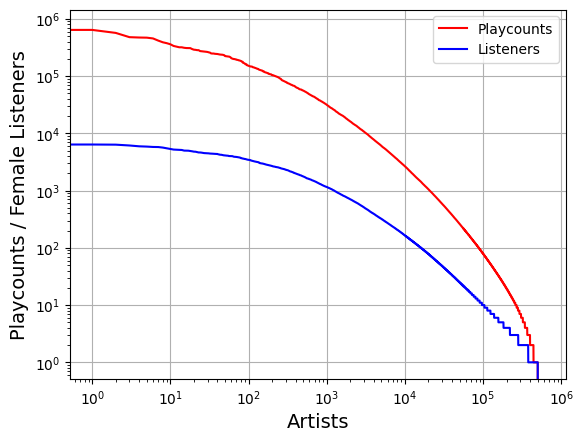

Avg_playcount =  336.336762406105
Sdev_playcount =  4614.235449597868
Avg_users =  16.903603688289937
Sdev_users =  110.04627035310561
Avg_MeanPC =  nan
Sdev_MeanPC =  nan
Avg_MedianPC =  nan
Sdev_MedianPC =  nan


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt


STATISTICS_OUTPUT_FILE_FEM = 'LFM-1b_stats_users.txt'   # output file for statistics

# Main program
if __name__ == '__main__':
    # Loading figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_FEM)

    # Plotting the sorted playcounts and listeners on a log-log scale
    handle_tpc, = plt.loglog(range(data[:,0].__len__()), sorted(data[:,0], reverse=True), 'r-')
    handle_uqa, = plt.loglog(range(data[:,1].__len__()), sorted(data[:,1], reverse=True), 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Listeners'])


    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Female Listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

    # Determine additional statistics of the listening events distribution
    Avg_playcount = np.mean(data[:, 0])     # Calculating the average playcount
    Sdev_playcount = np.std(data[:, 0])     # Calculating the standard deviation of playcounts
    Avg_users = np.mean(data[:, 1])         # Calculating the average number of users
    Sdev_users = np.std(data[:, 1])         # Calculating the standard deviation of the number of users
    Avg_MeanPC = np.mean(data[:, 2])        # Calculating the average mean playcount per listener
    Sdev_MeanPC = np.std(data[:, 2])        # Calculating the standard deviation of mean playcount per listener
    Avg_MedianPC = np.mean(data[:, 4])      # Calculating the average median playcount per listener
    Sdev_MedianPC = np.std(data[:, 4])      # Calculating the standard deviation of median playcount per listener


    # Print the computed statistics
    print("Avg_playcount = ", Avg_playcount)
    print("Sdev_playcount = ", Sdev_playcount)
    print("Avg_users = ", Avg_users)
    print("Sdev_users = ", Sdev_users)
    print("Avg_MeanPC = ", Avg_MeanPC)
    print("Sdev_MeanPC = ", Sdev_MeanPC)
    print("Avg_MedianPC = ", Avg_MedianPC)
    print("Sdev_MedianPC = ", Sdev_MedianPC)

Plotting and calculating values of female listening events and playcounts for top  played artist, 1000th most popular and 100000th least popular artist

Play counts (red plot) at x = 10^0, 10^3, and 10^5: [740620.0, 31509.0, 79.0]
Listeners (blue plot) at x = 10^0, 10^3, and 10^5: [6721.0, 1157.0, 10.0]


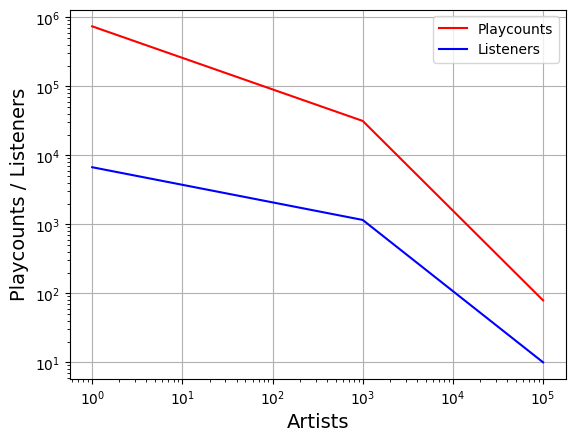

In [ ]:
STATISTICS_OUTPUT_FILE_FEM = 'LFM-1b_stats_users.txt'  # output file for statistics

# Main program
if __name__ == '__main__':
    # Loading figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_FEM)

    # Getting sorted data
    sorted_tpc = sorted(data[:, 0], reverse=True)
    sorted_uqa = sorted(data[:, 1], reverse=True)

    # Getting x-axis values at 10^0, 10^3, and 10^5
    x_values = [10 ** 0, 10 ** 3, 10 ** 5]

    # Getting y-axis values at x = 10^0, 10^3, and 10^5
    y_values_tpc = [sorted_tpc[0], sorted_tpc[min(10**3, len(sorted_tpc)-1)], sorted_tpc[min(10**5, len(sorted_tpc)-1)]]
    y_values_uqa = [sorted_uqa[0], sorted_uqa[min(10**3, len(sorted_uqa)-1)], sorted_uqa[min(10**5, len(sorted_uqa)-1)]]

    print("Play counts (red plot) at x = 10^0, 10^3, and 10^5:", y_values_tpc)
    print("Listeners (blue plot) at x = 10^0, 10^3, and 10^5:", y_values_uqa)

    # Plotting the data
    handle_tpc, = plt.loglog(x_values, y_values_tpc, 'r-')
    handle_uqa, = plt.loglog(x_values, y_values_uqa, 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Listeners'])

    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

Extracting male user and artist data from the UAM and computing some basic statistics  

In [ ]:
# importing the required librariries for reading the matlab file and loading the UAM
import numpy as np
import h5py
from scipy import sparse

# Defining the file names
UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'
USER_DATA_FILE = 'output_data_new.txt'
STATISTICS_OUTPUT_FILE_MALE = 'LFM-1b_stats_users.txt'

# Function to read the User-Artist Matrix (UAM) from a MATLAB file and process user data
def read_UAM(m_file, user_data_file):
    mf = h5py.File(m_file, 'r') # Opening the MATLAB file using h5py

    # Reading the user and artist indices from the MATLAB file and converting them to np.int64
    user_ids = np.array(mf['idx_users']).astype(np.int64)[:47586]  # slicing notation to extract a subset
    artist_ids = np.array(mf['idx_artists']).astype(np.int64)

    # Loading the UAM
    # Converting the sparse UAM data from the MATLAB file into a CSR sparse matrix
    UAM = sparse.csr_matrix((mf['/LEs/']['data'][()],
                             mf['/LEs/']['ir'][()],
                             mf['/LEs/']['jc'][()])).transpose()

    # Reading gender and filtering only male information from user data file
    # Loading the user data from the tab-separated file, skipping the header (first row)
    user_data = np.loadtxt(user_data_file, dtype=np.str_, delimiter='\t', skiprows=1)

    # Extracting the gender information and converting it to binary values (1 for male, 0 for female)
    gender_ids = (user_data[:, 3] == 'm').astype(np.int64)

    # Selecting only the male user IDs from the UAM and limiting the number to 47586
    # Filtering users based on gender (male)
    female_user_ids = user_ids[gender_ids == 1][:47586]

    # Find the common users between the user data file and UAM
    common_users = np.intersect1d(user_ids, female_user_ids)

    # Get the indices of common users in the UAM
    user_indices = np.where(np.isin(user_ids, common_users))[0]
    artist_indices = np.where(np.isin(artist_ids, artist_ids))[0]
    UAM = UAM[user_indices][:, artist_indices]

    # Getting the user and artist indices to access UAM
    UAM_user_idx = UAM.indices
    UAM_artist_idx = UAM.indptr

    # Returning the processed UAM and additional data
    return UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids


if __name__ == '__main__':
    # Reading the UAM
    UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids = read_UAM(UAM_MATLAB_FILE, USER_DATA_FILE)
    print('Male Users: ', len(common_users))
    print('Artists: ', len(artist_ids))

    # Computing some basic statistics with respect to the number of listeners each artist has
    pc_sum = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_unique_artist = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_mean = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_median = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_std = np.zeros((len(artist_ids)), dtype=np.float32)

    for i in range(0, len(artist_ids)):  # Looping over all artists
        pc_i = UAM.getcol(i).toarray()  # To get the column corresponding to the artist
        idx_nz = np.nonzero(pc_i)
        pc_unique_artist[i] = len(idx_nz[0])  # Number of listeners for the artist
        pc_sum[i] = np.sum(pc_i[idx_nz])
        pc_mean[i] = np.mean(pc_i[idx_nz])
        pc_std[i] = np.std(pc_i[idx_nz])
        pc_median[i] = np.median(pc_i[idx_nz])
        print('Artist ' + str(i) + " Playcount: " + str(pc_sum[i]) +
              "   Listeners: " + str(pc_unique_artist[i]) +
              "   Mean PC/listener: " + str(pc_mean[i]) +
              "   Std. PC/listener: " + str(pc_std[i]) +
              "   Median PC/listener: " + str(pc_median[i]))

    # Store to the computed statistics to a file
    np.savetxt(STATISTICS_OUTPUT_FILE_MALE, np.column_stack((pc_sum, pc_unique_artist, pc_mean, pc_std, pc_median)), fmt="%.3f")


Streaming output truncated to the last 5000 lines.
Artist 580095 Playcount: 1   Listeners: 1   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median PC/listener: 1.0
Artist 580096 Playcount: 3   Listeners: 3   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median PC/listener: 1.0
Artist 580097 Playcount: 1   Listeners: 1   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median PC/listener: 1.0
Artist 580098 Playcount: 1122   Listeners: 104   Mean PC/listener: 10.788462   Std. PC/listener: 31.116924   Median PC/listener: 2.0
Artist 580099 Playcount: 3545   Listeners: 85   Mean PC/listener: 41.705883   Std. PC/listener: 88.57125   Median PC/listener: 9.0
Artist 580100 Playcount: 6   Listeners: 3   Mean PC/listener: 2.0   Std. PC/listener: 0.8164966   Median PC/listener: 2.0
Artist 580101 Playcount: 7   Listeners: 2   Mean PC/listener: 3.5   Std. PC/listener: 2.5   Median PC/listener: 3.5
Artist 580102 Playcount: 1   Listeners: 1   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median 

Plotting graph for the distribution of listening events by artists (the number of male listeners for the artist)

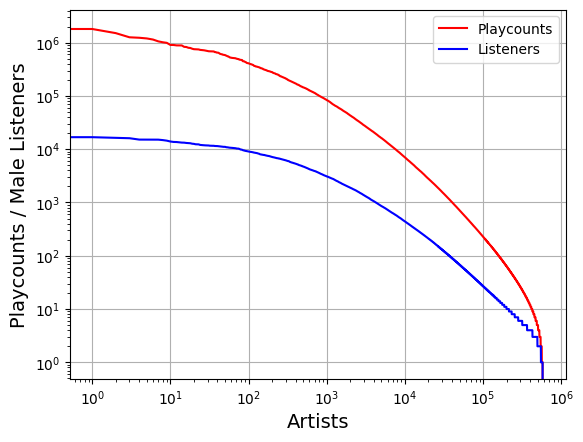

Avg_playcount =  899.906006716858
Sdev_playcount =  12187.56617200618
Avg_users =  45.655124381510696
Sdev_users =  293.33800202533865
Avg_MeanPC =  nan
Sdev_MeanPC =  nan
Avg_MedianPC =  nan
Sdev_MedianPC =  nan


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt


STATISTICS_OUTPUT_FILE_MALE = 'LFM-1b_stats_users.txt'         # output file for statistics

# Main program
if __name__ == '__main__':
    # Loading figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_MALE)

    # Plotting the sorted playcounts and listeners on a log-log scale
    handle_tpc, = plt.loglog(range(data[:,0].__len__()), sorted(data[:,0], reverse=True), 'r-')
    handle_uqa, = plt.loglog(range(data[:,1].__len__()), sorted(data[:,1], reverse=True), 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Listeners'])


    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Male Listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

    # Determining additional statistics of the listening events distribution
    Avg_playcount = np.mean(data[:, 0])    # Calculating the average playcount
    Sdev_playcount = np.std(data[:, 0])    # Calculating the standard deviation of playcounts
    Avg_users = np.mean(data[:, 1])        # Calculating the average number of users
    Sdev_users = np.std(data[:, 1])        # Calculating the standard deviation of the number of users
    Avg_MeanPC = np.mean(data[:, 2])       # Calculating the average mean playcount per listener
    Sdev_MeanPC = np.std(data[:, 2])       # Calculating the standard deviation of mean playcount per listener
    Avg_MedianPC = np.mean(data[:, 4])     # Calculating the average median playcount per listener
    Sdev_MedianPC = np.std(data[:, 4])     # Calculating the standard deviation of median playcount per listener


    # Print the computed statistics
    print("Avg_playcount = ", Avg_playcount)
    print("Sdev_playcount = ", Sdev_playcount)
    print("Avg_users = ", Avg_users)
    print("Sdev_users = ", Sdev_users)
    print("Avg_MeanPC = ", Avg_MeanPC)
    print("Sdev_MeanPC = ", Sdev_MeanPC)
    print("Avg_MedianPC = ", Avg_MedianPC)
    print("Sdev_MedianPC = ", Sdev_MedianPC)

Plotting and calculating values of male listening events and playcounts for top  played artist, 1000th most popular and 100000th least popular artist

Play counts (red plot) at x = 10^0, 10^3, and 10^5: [2025018.0, 83690.0, 227.0]
Male Listeners (blue plot) at x = 10^0, 10^3, and 10^5: [17669.0, 3086.0, 27.0]


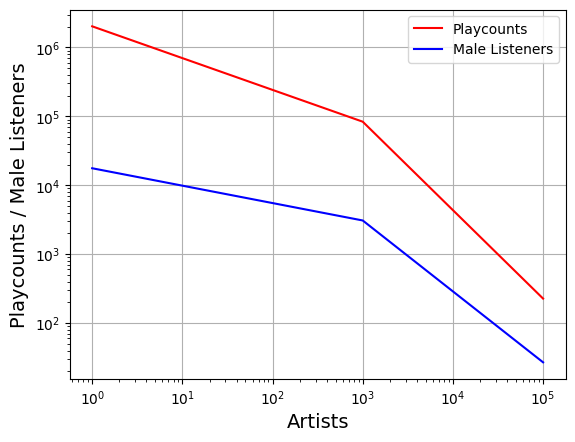

In [ ]:
STATISTICS_OUTPUT_FILE_MALE = 'LFM-1b_stats_users.txt'  # output file for statistics

# Main program
if __name__ == '__main__':
    # Loading the figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_MALE)

    # Getting sorted data
    sorted_tpc = sorted(data[:, 0], reverse=True)
    sorted_uqa = sorted(data[:, 1], reverse=True)

    # Getting x-axis values at 10^0, 10^3, and 10^5
    x_values = [10 ** 0, 10 ** 3, 10 ** 5]

    # Gettin y-axis values at x = 10^0, 10^3, and 10^5
    y_values_tpc = [sorted_tpc[0], sorted_tpc[min(10**3, len(sorted_tpc)-1)], sorted_tpc[min(10**5, len(sorted_tpc)-1)]]
    y_values_uqa = [sorted_uqa[0], sorted_uqa[min(10**3, len(sorted_uqa)-1)], sorted_uqa[min(10**5, len(sorted_uqa)-1)]]

    print("Play counts (red plot) at x = 10^0, 10^3, and 10^5:", y_values_tpc)
    print("Male Listeners (blue plot) at x = 10^0, 10^3, and 10^5:", y_values_uqa)

    # Plotting the data
    handle_tpc, = plt.loglog(x_values, y_values_tpc, 'r-')
    handle_uqa, = plt.loglog(x_values, y_values_uqa, 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Male Listeners'])

    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Male Listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

Extracting Overall - female & male user and artist data from the UAM and computing some basic statistics

In [ ]:
# importing the required librariries for reading the matlab file and loading the UAM
import numpy as np
import h5py
from scipy import sparse

# Defining the file names
UAM_MATLAB_FILE = 'LFM-1b_LEs.mat'
USER_DATA_FILE = 'output_data_new.txt'
STATISTICS_OUTPUT_FILE_BOTH = 'LFM-1b_stats_users.txt'

# Function to read the User-Artist Matrix (UAM) from a MATLAB file and process user data
def read_UAM(m_file, user_data_file):
    mf = h5py.File(m_file, 'r')# Opening the MATLAB file using h5py

    # Reading the user and artist indices from the MATLAB file and converting them to np.int64
    user_ids = np.array(mf['idx_users']).astype(np.int64)[:47586]    #Slicing notation to extract a subset
    artist_ids = np.array(mf['idx_artists']).astype(np.int64)

    # Loading the UAM
    # Converting the sparse UAM data from the MATLAB file into a CSR sparse matrix
    UAM = sparse.csr_matrix((mf['/LEs/']['data'][()],
                             mf['/LEs/']['ir'][()],
                             mf['/LEs/']['jc'][()])).transpose()

    # Reading gender and filtering only male information from user data file
    # Loading the user data from the tab-separated file, skipping the header (first row)
    user_data = np.loadtxt(user_data_file, dtype=np.str_, delimiter='\t', skiprows=1)

    # Extracting the gender information and converting it to binary values (1 for male, 0 for female)
    gender_ids = np.isin(user_data[:, 3], ['f', 'm']).astype(np.int64)

    # Filtering users based on both gender (female & male)
    both_user_ids = user_ids[gender_ids == 1][:47586]

    # Finding the common users between the user data file and UAM
    common_users = np.intersect1d(user_ids, both_user_ids)

    # Geting the indices of common users in the UAM
    user_indices = np.where(np.isin(user_ids, common_users))[0]
    artist_indices = np.where(np.isin(artist_ids, artist_ids))[0]
    UAM = UAM[user_indices][:, artist_indices]

    # Get the user and artist indices to access UAM
    UAM_user_idx = UAM.indices
    UAM_artist_idx = UAM.indptr
    return UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids


if __name__ == '__main__':
    # Read UAM
    UAM, UAM_user_idx, UAM_artist_idx, common_users, artist_ids = read_UAM(UAM_MATLAB_FILE, USER_DATA_FILE)
    print('Male Users: ', len(common_users))
    print('Artists: ', len(artist_ids))

    # Compute some basic statistics with respect to the number of listeners each artist has
    pc_sum = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_unique_artist = np.zeros((len(artist_ids)), dtype=np.int32)
    pc_mean = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_median = np.zeros((len(artist_ids)), dtype=np.float32)
    pc_std = np.zeros((len(artist_ids)), dtype=np.float32)

    for i in range(0, len(artist_ids)):  # Loop over all artists
        pc_i = UAM.getcol(i).toarray()  # Get the column corresponding to the artist
        idx_nz = np.nonzero(pc_i)
        pc_unique_artist[i] = len(idx_nz[0])  # Number of listeners for the artist
        pc_sum[i] = np.sum(pc_i[idx_nz])
        pc_mean[i] = np.mean(pc_i[idx_nz])
        pc_std[i] = np.std(pc_i[idx_nz])
        pc_median[i] = np.median(pc_i[idx_nz])
        print('Artist ' + str(i) + " Playcount: " + str(pc_sum[i]) +
              "   Listeners: " + str(pc_unique_artist[i]) +
              "   Mean PC/listener: " + str(pc_mean[i]) +
              "   Std. PC/listener: " + str(pc_std[i]) +
              "   Median PC/listener: " + str(pc_median[i]))

    # Store to the computed statistics to a file
    np.savetxt(STATISTICS_OUTPUT_FILE_BOTH, np.column_stack((pc_sum, pc_unique_artist, pc_mean, pc_std, pc_median)), fmt="%.3f")



Streaming output truncated to the last 5000 lines.
Artist 580095 Playcount: 1   Listeners: 1   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median PC/listener: 1.0
Artist 580096 Playcount: 3   Listeners: 3   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median PC/listener: 1.0
Artist 580097 Playcount: 3   Listeners: 2   Mean PC/listener: 1.5   Std. PC/listener: 0.5   Median PC/listener: 1.5
Artist 580098 Playcount: 1267   Listeners: 144   Mean PC/listener: 8.798611   Std. PC/listener: 26.746645   Median PC/listener: 2.0
Artist 580099 Playcount: 4176   Listeners: 112   Mean PC/listener: 37.285713   Std. PC/listener: 81.28877   Median PC/listener: 8.0
Artist 580100 Playcount: 9   Listeners: 5   Mean PC/listener: 1.8   Std. PC/listener: 0.7483315   Median PC/listener: 2.0
Artist 580101 Playcount: 7   Listeners: 2   Mean PC/listener: 3.5   Std. PC/listener: 2.5   Median PC/listener: 3.5
Artist 580102 Playcount: 1   Listeners: 1   Mean PC/listener: 1.0   Std. PC/listener: 0.0   Median 

Plotting graph for the distribution of listening events by artists (the number of female, male listeners for the artist)

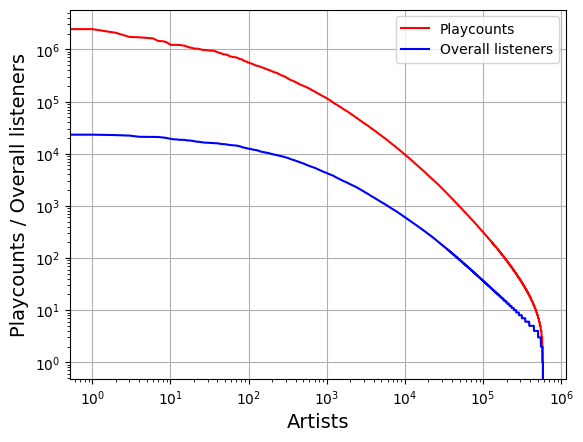

Avg_playcount =  1236.242769122963
Sdev_playcount =  16758.483243419436
Avg_users =  62.55872806980063
Sdev_users =  403.2905535546634
Avg_MeanPC =  nan
Sdev_MeanPC =  nan
Avg_MedianPC =  nan
Sdev_MedianPC =  nan


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt


STATISTICS_OUTPUT_FILE_BOTH = 'LFM-1b_stats_users.txt'

# Main program
if __name__ == '__main__':
    # Loading figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_BOTH)

    # Plotting the sorted playcounts and listeners on a log-log scale
    handle_tpc, = plt.loglog(range(data[:,0].__len__()), sorted(data[:,0], reverse=True), 'r-')
    handle_uqa, = plt.loglog(range(data[:,1].__len__()), sorted(data[:,1], reverse=True), 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Overall listeners'])


    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Overall listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

    # Determining additional statistics of the listening events distribution
    Avg_playcount = np.mean(data[:, 0])    # Calculating the average playcount
    Sdev_playcount = np.std(data[:, 0])    # Calculating the standard deviation of  playcount
    Avg_users = np.mean(data[:, 1])        # Calculating the average number of users
    Sdev_users = np.std(data[:, 1])        # Calculating the standard deviation of the number of users
    Avg_MeanPC = np.mean(data[:, 2])       # Calculating the average mean playcount per listener
    Sdev_MeanPC = np.std(data[:, 2])       # Calculating the standard deviation of mean playcount per listener
    Avg_MedianPC = np.mean(data[:, 4])     # Calculating the average median playcount per listener
    Sdev_MedianPC = np.std(data[:, 4])     # Calculating the standard deviation of median playcount per listener

    # Printing the computed statistics
    print("Avg_playcount = ", Avg_playcount)
    print("Sdev_playcount = ", Sdev_playcount)
    print("Avg_users = ", Avg_users)
    print("Sdev_users = ", Sdev_users)
    print("Avg_MeanPC = ", Avg_MeanPC)
    print("Sdev_MeanPC = ", Sdev_MeanPC)
    print("Avg_MedianPC = ", Avg_MedianPC)
    print("Sdev_MedianPC = ", Sdev_MedianPC)

Plotting and calculating values of female and male listening events and playcounts for top  played artist, 1000th most popular and 100000th least popular artist

Play counts (red plot) at x = 10^0, 10^3, and 10^5: [2765638.0, 115198.0, 313.0]
Male Listeners (blue plot) at x = 10^0, 10^3, and 10^5: [24390.0, 4240.0, 36.0]


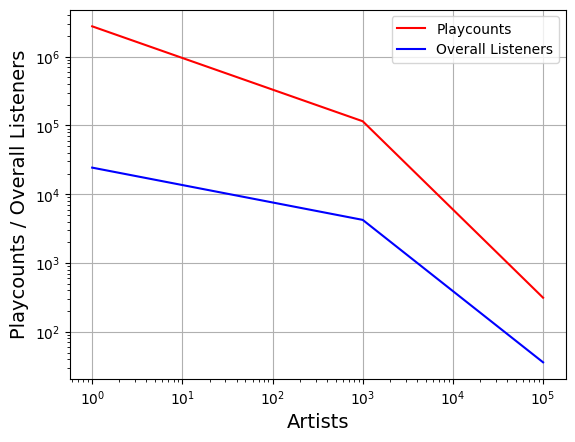

In [ ]:
STATISTICS_OUTPUT_FILE_BOTH = 'LFM-1b_stats_users.txt'  # output file for statistics

# Main program
if __name__ == '__main__':
    # Load figures from file
    data = np.loadtxt(STATISTICS_OUTPUT_FILE_BOTH)

    # Get sorted data
    sorted_tpc = sorted(data[:, 0], reverse=True)
    sorted_uqa = sorted(data[:, 1], reverse=True)

    # Get x-axis values at 10^0, 10^3, and 10^5
    x_values = [10 ** 0, 10 ** 3, 10 ** 5]

    # Get y-axis values at x = 10^0, 10^3, and 10^5
    y_values_tpc = [sorted_tpc[0], sorted_tpc[min(10**3, len(sorted_tpc)-1)], sorted_tpc[min(10**5, len(sorted_tpc)-1)]]
    y_values_uqa = [sorted_uqa[0], sorted_uqa[min(10**3, len(sorted_uqa)-1)], sorted_uqa[min(10**5, len(sorted_uqa)-1)]]

    print("Play counts (red plot) at x = 10^0, 10^3, and 10^5:", y_values_tpc)
    print("Male Listeners (blue plot) at x = 10^0, 10^3, and 10^5:", y_values_uqa)

    # Plot the data
    handle_tpc, = plt.loglog(x_values, y_values_tpc, 'r-')
    handle_uqa, = plt.loglog(x_values, y_values_uqa, 'b-')
    plt.legend([handle_tpc, handle_uqa], ['Playcounts', 'Overall Listeners'])

    plt.xlabel('Artists', fontsize=14)
    plt.ylabel('Playcounts / Overall Listeners', fontsize=14)
    plt.grid(True)
    plt.savefig('LFM-1b_user_plot.eps', format='eps', dpi=1000)
    plt.show()

**Please Note: The basic codes were provided by Markus Schedl but the extension are my work **